In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd
import os
import numpy as np
import re

# preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss

import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/eshza/medicalTranscriptsKaggle/master/mtsamples.csv', index_col=0)

In [ ]:
df.astype(str)
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
df["keywords"].str.split(", ")

0       [allergy / immunology, allergic rhinitis, alle...
1       [bariatrics, laparoscopic gastric bypass, weig...
2       [bariatrics, laparoscopic gastric bypass, hear...
3       [cardiovascular / pulmonary, 2-d m-mode, doppl...
4       [cardiovascular / pulmonary, 2-d, doppler, ech...
                              ...                        
4994                                                  NaN
4995    [allergy / immunology, mucous membranes, conju...
4996                                                  NaN
4997                                                  NaN
4998                                                  NaN
Name: keywords, Length: 4999, dtype: object

In [ ]:
def text_prepare(text):

    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@\-,.;#&]')
    BAD_SYMBOLS_RE = re.compile('[0-9][0-9a-z ][#+_]{1,}')
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    words = text.split()
    i = 0
    while i < len(words):
        if words[i] in STOPWORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text
    
    return text
def text_prepare_keywords(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@\-.,;#&]')
    BAD_SYMBOLS_RE = re.compile('[0-9][0-9a-z #+%_]')
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    words = text.split()
    i = 0
    while i < len(words):
        if words[i] in STOPWORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text
    
    return text

In [ ]:
df['keywords'].replace('', np.nan, inplace=True)
df = df.drop(df[df['transcription'].isna()].index)
df = df.drop(df[df['keywords'].isna()].index)

In [ ]:
df['transcription'] = df['transcription'].str.replace(r'[0-9-A-Z\s]+:', '')
df['keywords'] = df['keywords'].str.replace(r'[0-9-A-Z\s]+:', '')
df['keywords'] = df['keywords'].str.replace(r'(, *)?$', '')
df['keywords'] = df['keywords'].str.replace(r'^( *,)?', '')
df['keywords'] = df['keywords'].str.replace(r'\s{2,}', '')
df['keywords'] = df['keywords'].str.replace(r'%', '')
df.loc[:, 'transcription'] = [text_prepare(x) for x in df['transcription'].values]
df.loc[:, 'keywords'] = [text_prepare_keywords(x) for x in df['keywords'].values]

In [ ]:
tokenizer = RegexpTokenizer(r'[\w\'-]+')
df["tokens_keywords"] = df["keywords"].apply(tokenizer.tokenize)
df["tokens_keywords"].head()

0    [allergy, immunology, allergic, rhinitis, alle...
1    [bariatrics, laparoscopic, gastric, bypass, we...
2    [bariatrics, laparoscopic, gastric, bypass, he...
3    [cardiovascular, pulmonary, mode, doppler, aor...
4    [cardiovascular, pulmonary, doppler, echocardi...
Name: tokens_keywords, dtype: object

In [ ]:
df["keyword_count"] = df['keywords'].apply(lambda text: len(text.split(" ")))
df.head()

,description,medical_specialty,sample_name,transcription,keywords,tokens_keywords,keyword_count
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,23 year old white female presents complaint al...,allergy immunology allergic rhinitis allergies...,"[allergy, immunology, allergic, rhinitis, alle...",14
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,difficulty climbing stairs difficulty airline ...,bariatrics laparoscopic gastric bypass weight ...,"[bariatrics, laparoscopic, gastric, bypass, we...",28
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,seen abc today pleasant gentleman 42 years old...,bariatrics laparoscopic gastric bypass heart a...,"[bariatrics, laparoscopic, gastric, bypass, he...",27
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,1 left atrial enlargement left atrial diameter...,cardiovascular pulmonary mode doppler aortic v...,"[cardiovascular, pulmonary, mode, doppler, aor...",27
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1 left ventricular cavity size wall thickness ...,cardiovascular pulmonary doppler echocardiogra...,"[cardiovascular, pulmonary, doppler, echocardi...",33


In [ ]:
df.keyword_count.value_counts()

16    218
15    200
17    196
18    188
19    181
     ... 
90      2
54      1
86      1
53      1
55      1
Name: keyword_count, Length: 85, dtype: int64

In [ ]:
# using count vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(' '))

keywords_dtm = vectorizer.fit_transform(df['keywords'])

In [ ]:
print("Number of data points :", keywords_dtm.shape[0])
print("Number of unique tags :", keywords_dtm.shape[1])

Number of data points : 3898
Number of unique tags : 5839


In [ ]:
# Storing the count of tag in each transcription in the list 'tag_count
tag_quest_count = keywords_dtm.sum(axis=1).tolist()

# converting list of lists into single list,we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print('We have total {} datapoints.'.format(len(tag_quest_count)))
print(tag_quest_count[:5])

We have total 3817 datapoints.
[14, 28, 27, 27, 33]


In [ ]:
print ("Maximum no of tag per transcription: %d"%max(tag_quest_count))
print ("Minimum no of tags per transcription: %d"%min(tag_quest_count))
print ("Avg number of tags per transcription: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum no of tag per transcription: 89
Minimum no of tags per transcription: 1
Avg number of tags per transcription: 23.926906


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


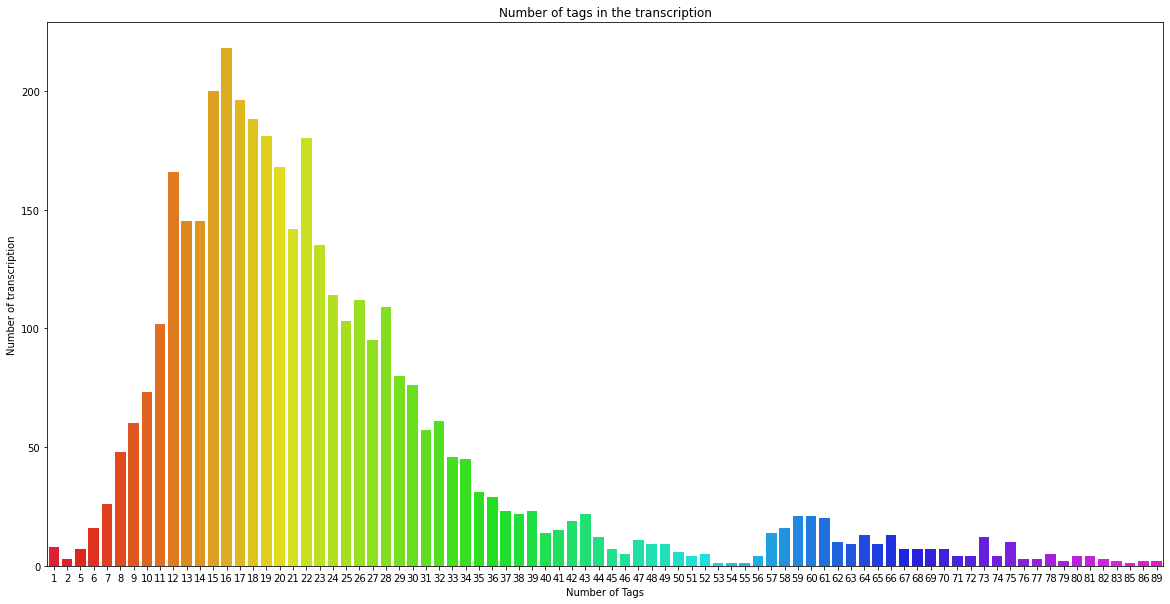

In [ ]:
fig = plt.figure(figsize=(20,10))
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the transcription")
plt.xlabel("Number of Tags")
plt.ylabel("Number of transcription")
plt.show()

In [ ]:
#Lets now store the document term matrix in a dictionary.
freqs = keywords_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [ ]:
tag_df = pd.DataFrame({'Tags': tags, 'Counts': freqs})
tag_df.head()

,Tags,Counts
0,abc,3
1,abd,3
2,abdomen,188
3,abdomennote,2
4,abdominal,193


In [ ]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

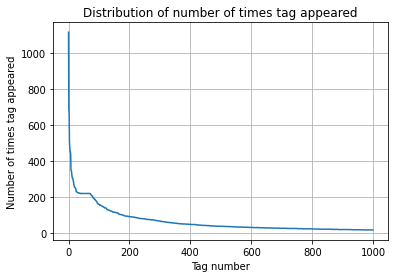

In [ ]:
plt.plot(tag_counts[:1000])
plt.title("Distribution of number of times tag appeared")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

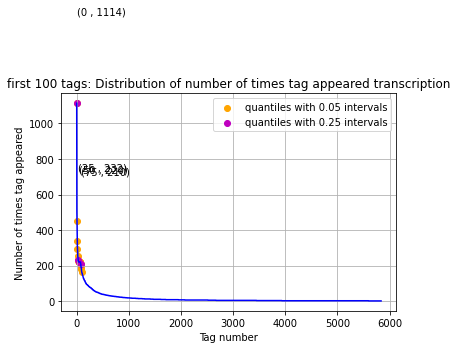

20 [1114  452  339  293  255  232  224  222  220  220  220  220  220  220
  220  210  198  188  180  165]


In [ ]:
plt.plot(tag_counts, c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared transcription')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

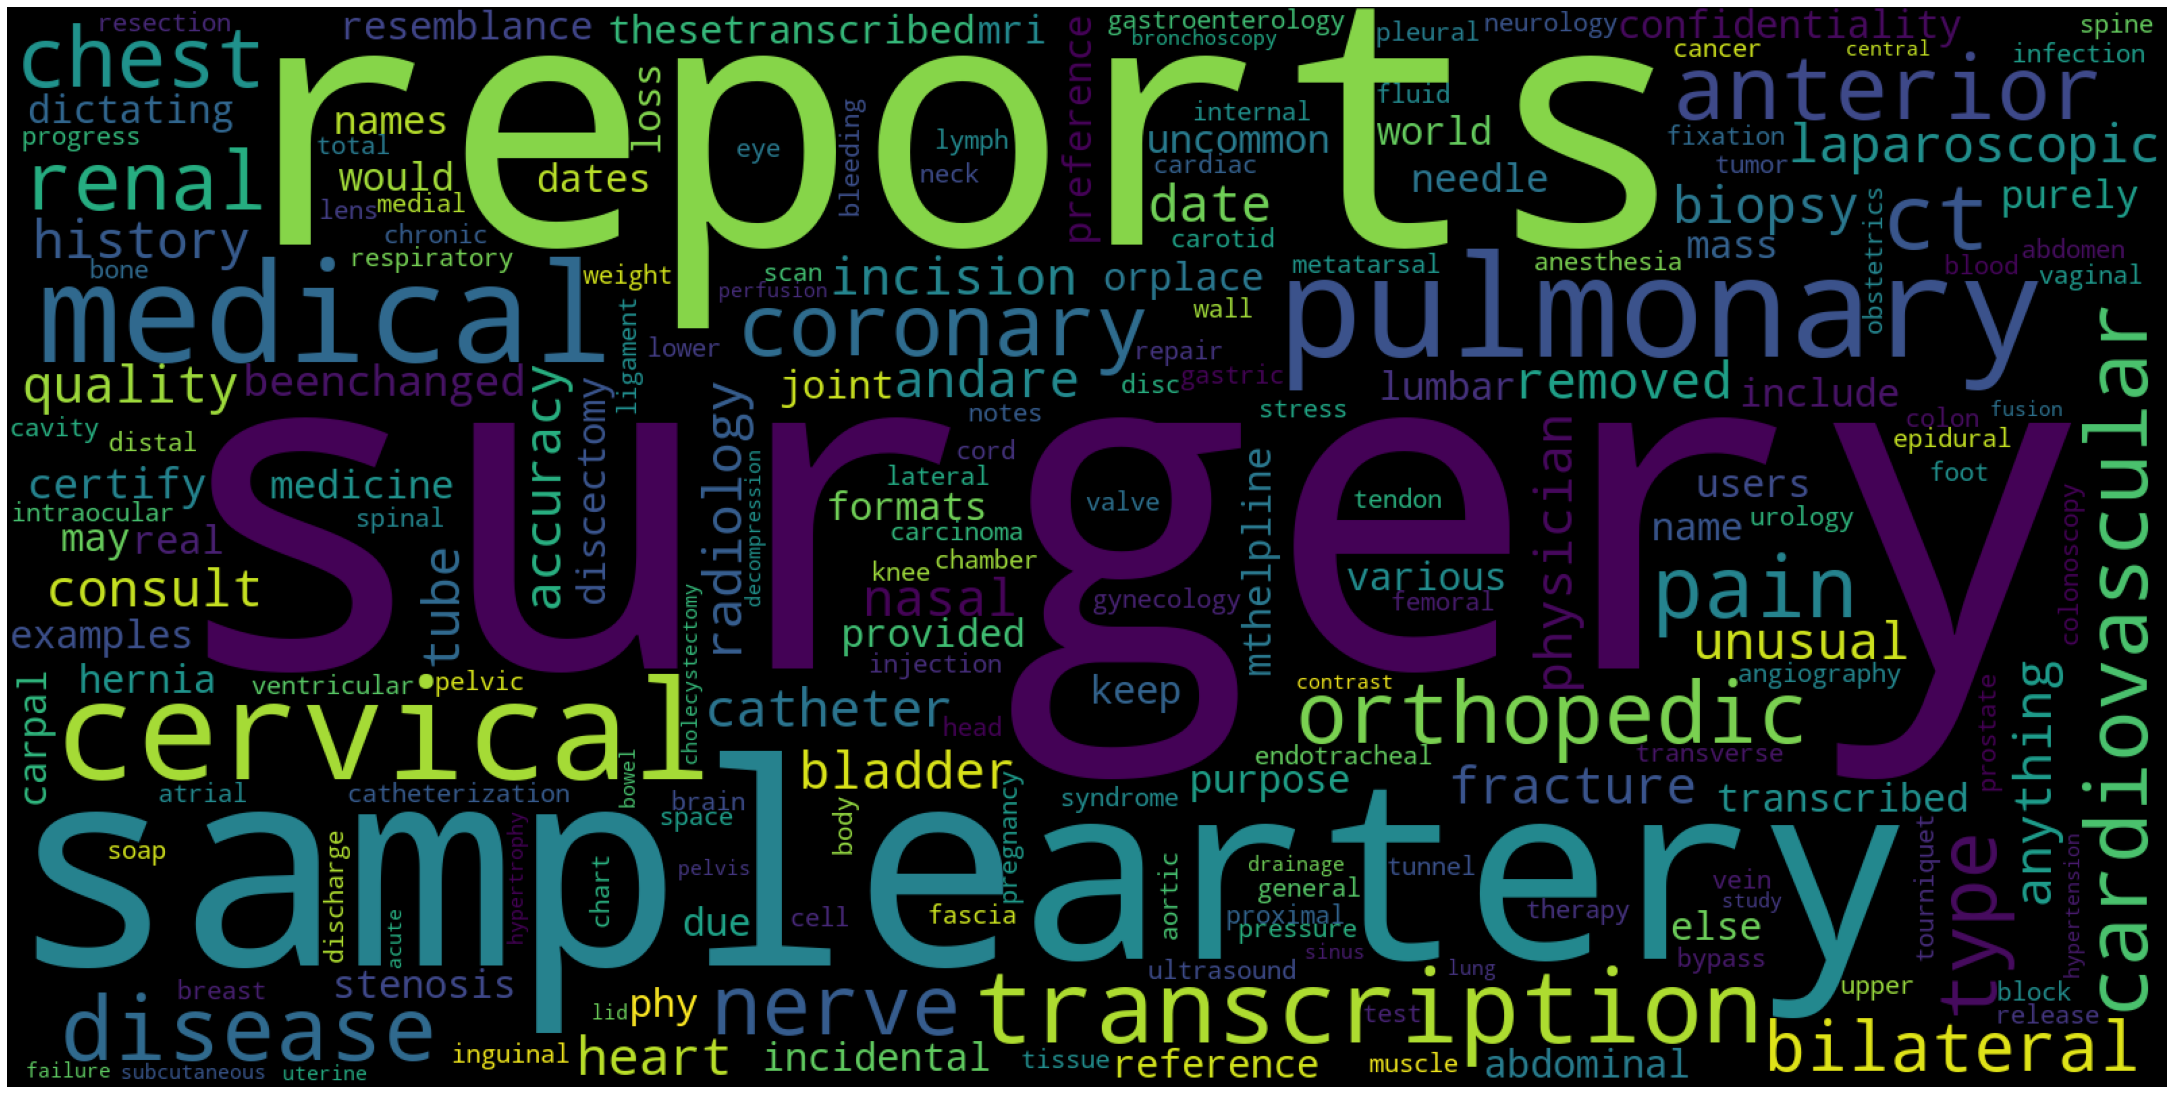

Time taken to run this cell : 0:00:05.156887


In [ ]:
import datetime
from wordcloud import WordCloud
# Ploting word cloud
start = datetime.datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.datetime.now() - start)

<Figure size 1440x720 with 0 Axes>

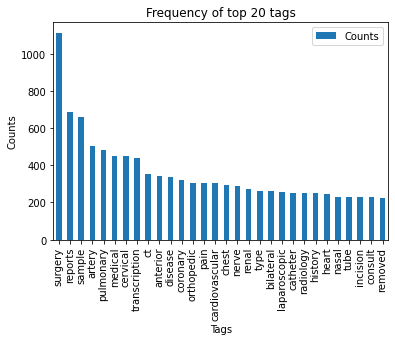

In [ ]:
i=np.arange(30)
fig = plt.figure(figsize=(20,10))
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


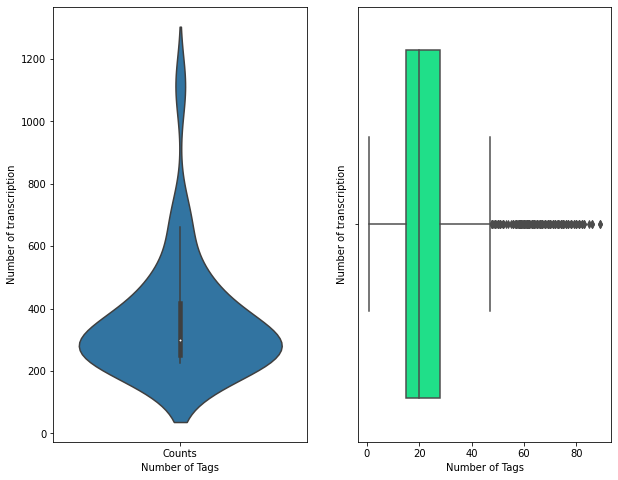

In [ ]:
# Obsetving the quantiles using the violin plot and box .

plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(data = tag_df_sorted.head(30) , )
plt.xlabel("Number of Tags")
plt.ylabel("Number of transcription")

plt.subplot(1,2,2)
sns.boxplot(tag_quest_count, palette='gist_rainbow')
plt.xlabel("Number of Tags")
plt.ylabel("Number of transcription")
plt.show()

In [ ]:
df.drop(['description', 'medical_specialty', 'sample_name', 'tokens_keywords'], axis=1, inplace=True)

In [ ]:
df.head()

,transcription,keywords,keyword_count
0,23 year old white female presents complaint al...,allergy immunology allergic rhinitis allergies...,14
1,difficulty climbing stairs difficulty airline ...,bariatrics laparoscopic gastric bypass weight ...,28
2,seen abc today pleasant gentleman 42 years old...,bariatrics laparoscopic gastric bypass heart a...,27
3,1 left atrial enlargement left atrial diameter...,cardiovascular pulmonary mode doppler aortic v...,27
4,1 left ventricular cavity size wall thickness ...,cardiovascular pulmonary doppler echocardiogra...,33


In [ ]:
x_train=df.sample(frac=0.5, replace=True, random_state=1)
x_test=df.sample(frac=0.2, replace=True, random_state=1)

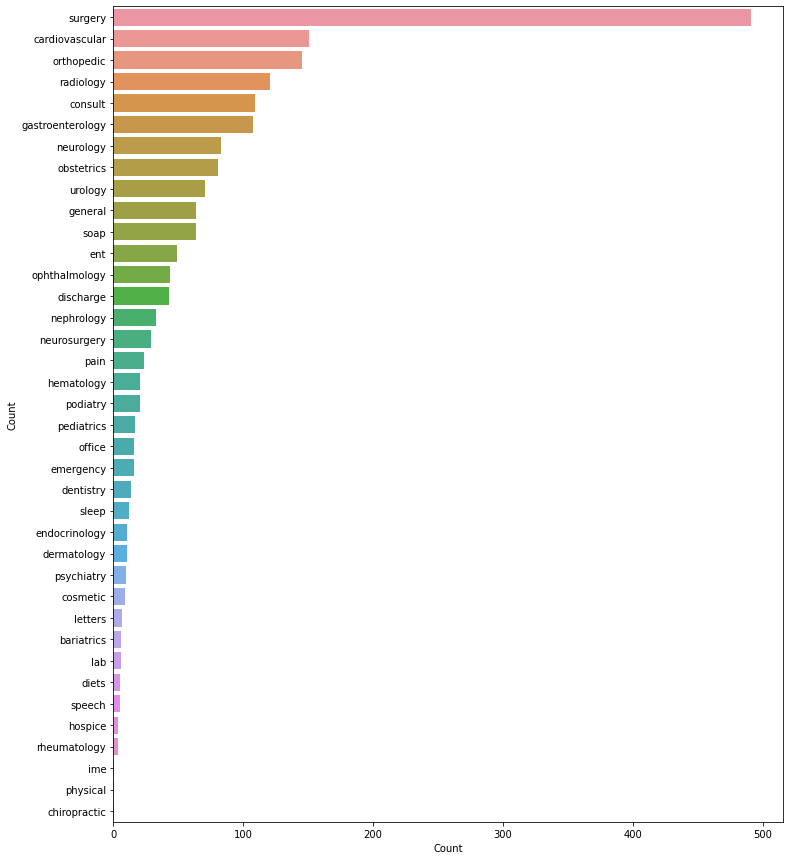

['surgery',
 'general',
 'cardiovascular',
 'gastroenterology',
 'urology',
 'nephrology',
 'consult',
 'soap',
 'neurology',
 'lab',
 'cosmetic',
 'ent',
 'radiology',
 'orthopedic',
 'obstetrics',
 'rheumatology',
 'hematology',
 'endocrinology',
 'podiatry',
 'sleep',
 'emergency',
 'bariatrics',
 'diets',
 'pediatrics',
 'discharge',
 'hospice',
 'pain',
 'speech',
 'neurosurgery',
 'ophthalmology',
 'letters',
 'dentistry',
 'psychiatry',
 'dermatology',
 'ime',
 'office',
 'physical',
 'chiropractic']

In [ ]:
import nltk
import seaborn as sns
all_genres = nltk.FreqDist(x_train["keywords"].apply(lambda x: x.split(' ')[0]))
all_genres_df = pd.DataFrame({'Keywords': list(all_genres.keys()), 'Count': list(all_genres.values())})
g = all_genres_df.nlargest(columns="Count", n = 100) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Keywords")
ax.set(ylabel = 'Count')
plt.show()
list(all_genres.keys())

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

X_train = np.array(x_train['transcription'])
Y_train = np.array(x_train['keywords'])
X_test = np.array(x_test['transcription'])
Y_test = np.array(x_test['keywords'])

model = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', class_weight="balanced", verbose=1), n_jobs=-1))
                      ])
model.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001,
                                                             average=False,
                                                             class_weight='balanced',
                                                             early_stopping=False,
                

In [ ]:
from sklearn.externals import joblib
joblib.dump(model, "pipeline1.pkl", compress=9)
prediction = model.predict(X_test)

In [ ]:
print("Accuracy :",accuracy_score(Y_test, prediction))
print("Hamming loss ",hamming_loss(Y_test,prediction))


precision = precision_score(Y_test, prediction, average='micro')
recall = recall_score(Y_test, prediction, average='micro')
f1 = f1_score(Y_test, prediction, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(Y_test, prediction, average='macro')
recall = recall_score(Y_test, prediction, average='macro')
f1 = f1_score(Y_test, prediction, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Accuracy : 0.6697247706422018
Hamming loss  0.3302752293577982
Micro-average quality numbers
Precision: 0.6697, Recall: 0.6697, F1-measure: 0.6697
Macro-average quality numbers
Precision: 0.5325, Recall: 0.5821, F1-measure: 0.5479


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Input: '+X_test[90])
prediction_row = model.predict([X_test[90]])
print('Output: '+prediction_row[0])
print('Actual: '+Y_test[90])

Input: 3 year old female patient admitted today history gagging well 2 days ago developed gagging vomiting fever history constipation normally passes stool every two days giving enema rectal bleeding brought hospital loose stool found dehydrated given iv fluid bolus started bleeding g tube site fresh blood coming g tube site transferred picu hypertensive intensivist dr x requested come look upper endoscopy find site bleeding peho syndrome infantile spasm right knee amputation developmental delay g tube fundoplication g tube fundoplication 05 25 2007 right knee amputation none npo home pediasure 4 ounces 3 times day g tube 12 ounces water per day albuterol pulmicort miralax 17 g week carnitine phenobarbital depakene reglan positive cancer 12 27 2007 wbc 9 3 hemoglobin 7 6 hematocrit 22 1 platelet 132 000 kub showed large stool dilated small large bowel loops sodium 140 potassium 4 4 chloride 89 co2 21 bun 61 creatinine 2 ast 92 increased alt 62 increased albumin 5 3 total bilirubin 0 1 